In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
business = pd.read_csv('/content/drive/MyDrive/YelpRecommender/Data/NewOrleans/business.csv',index_col=[0])
review = pd.read_csv('/content/drive/MyDrive/YelpRecommender/Data/NewOrleans/review.csv',index_col=[0])

In [ ]:
# Before working on the model let's split the data between test, train and validation data

# Now in the recommendation system We must design a train-test split where there are no new users
# or new businesses in the test set because the content-based recommendation ranking only functions
# with current customers and restaurants.

# Therefore we will use holdout method to achieve this.

In [4]:
review.columns

Index(['date', 'user_id', 'useful', 'cool', 'text', 'funny', 'review_id',
       'business_id', 'stars'],
      dtype='object')

In [ ]:
review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539474 entries, 0 to 539473
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         539474 non-null  object 
 1   user_id      539474 non-null  object 
 2   useful       539474 non-null  int64  
 3   cool         539474 non-null  int64  
 4   text         539474 non-null  object 
 5   funny        539474 non-null  int64  
 6   review_id    539474 non-null  object 
 7   business_id  539474 non-null  object 
 8   stars        539474 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 41.2+ MB


In [ ]:
business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3306 entries, 65 to 150251
Data columns (total 60 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   state                                  3306 non-null   object 
 1   attributes.RestaurantsPriceRange2      2748 non-null   float64
 2   attributes.RestaurantsCounterService   1 non-null      object 
 3   attributes.DietaryRestrictions         1 non-null      object 
 4   attributes.BestNights                  501 non-null    object 
 5   attributes.HairSpecializesIn           0 non-null      float64
 6   attributes.Ambience                    2215 non-null   object 
 7   attributes.NoiseLevel                  1949 non-null   object 
 8   attributes.Smoking                     351 non-null    object 
 9   attributes.GoodForMeal                 1369 non-null   object 
 10  hours.Tuesday                          2274 non-null   object 
 11  a

In [ ]:
#stratify cannot be an option, as equal proportion is not required rather random shuffling is required.


In [4]:
np.random.seed(42)
idx = np.array(review.index)
np.random.shuffle(idx)

In [5]:
train = review.loc[idx[:int(0.85*len(idx))]]
test = review.loc[idx[int(0.85*len(idx)):]]

In [ ]:
# Now let's check which reviews of user_id are there in test but not in train and send them back to train

In [6]:
test_only_userid = test[-test.user_id.isin(train.user_id.unique())]
len(test_only_userid)

21083

In [7]:
ids_test_only = test_only_userid['user_id'].drop_duplicates().index

In [8]:
train_all_idx = train.index.union(ids_test_only)
test_all_idx = review.index.difference(train_all_idx)

In [9]:
train = review.loc[train_all_idx]
test = review.loc[test_all_idx]

In [10]:
len(train)/(len(train)+len(test))

0.8873550903287276

In [11]:
len(test)/(len(train)+len(test))

0.11264490967127239

In [ ]:
# train vs test ratio now becomes 89:11

In [12]:
set(test.business_id) - set(train.business_id)

set()

In [ ]:
# There are no businesses in test which are unique and not present in train 
# so we do not need to modify our train and test

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478705 entries, 0 to 539473
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         478705 non-null  object 
 1   user_id      478705 non-null  object 
 2   useful       478705 non-null  int64  
 3   cool         478705 non-null  int64  
 4   text         478705 non-null  object 
 5   funny        478705 non-null  int64  
 6   review_id    478705 non-null  object 
 7   business_id  478705 non-null  object 
 8   stars        478705 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 36.5+ MB


In [ ]:
train.groupby('business_id')['text'].count().sort_values(ascending=False)


business_id
ac1AeYqs8Z4_e2X5M3if2A    6856
_ab50qdWOk0DdB6XOrBitw    6724
oBNrLz4EDhiscSlbOl8uAw    4685
iSRTaT9WngzB8JJ2YKJUig    4662
VQcCL9PiNL_wkGf-uF3fjg    4626
                          ... 
RatJCtQ8j4cG80vAPr9UAw       3
SgCU0hvmsSbY6uL3lmjJ6A       3
h9Qf7cOTUdzufvoRxWIFoA       2
4QdZHOqo7OI63SG6JnLdpg       2
moT5dbsX7v6aZgJcwDZrgw       2
Name: text, Length: 3306, dtype: int64

In [ ]:
# let's analyse the same business review together

In [ ]:
# Rather than joining them directly adding a seperator will be wise as to seperate later if required.

In [10]:
rev_by_business = train.groupby('business_id').agg({'review_id':'count', 'text':lambda x: '****'.join(x)})
rev_by_business = rev_by_business.rename(columns = {'review_id':'review_count','text':'all_reviews'})

In [11]:
rev_by_business = rev_by_business.reset_index()

In [15]:
rev_by_business.head()

,business_id,review_count,all_reviews
0,--x_BmZbxzK_nx_GHBaRVw,18,We lucked out and the other people for the tou...
1,--zb12mw2YK-7j6UaHzm8w,11,Billy Wright's Manuel's Style Hot Tamales are ...
2,-0__F9fnKt8uioCKztF5Ww,47,Great location and the rooftop lounge area of ...
3,-0ltw8--HLuulPyOSspqAQ,9,My daughter and her family stayed here for the...
4,-1XSzguS6XLN-V6MVZMg2A,480,Hands down this is my NEW favorite restaurant!...


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
rev_by_business.loc[:0.01*len(rev_by_business)]['all_reviews']

0     We lucked out and the other people for the tou...
1     Billy Wright's Manuel's Style Hot Tamales are ...
2     Great location and the rooftop lounge area of ...
3     My daughter and her family stayed here for the...
4     Hands down this is my NEW favorite restaurant!...
5     Don't even wast your time, very slow, always o...
6     Completely disappointed with how this location...
7     Don't be fooled by the exterior, this place is...
8     NASTY NASTY NASTY!!!!!! Steer clear.  I've bee...
9     OMG! So it's too bad they only allow 5 stars a...
10    This Snowball Shop is now in my Top Favorites....
11    Yes! I love this place! Maple Street Patisseri...
12    If you're looking for a great apple fritter GE...
13    If you ever travel from New Orleans to Slidell...
14    VERY good food. I get take out for lunch and y...
15    Krewe of Carrollton was a pretty fun parade.\n...
16    Their store is on Grubhub but doesn't work on ...
17    Horrible...they don't care about their cus

In [14]:
%%time
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,3),max_features=1500)
X = vectorizer.fit_transform(rev_by_business.loc[:0.01*len(rev_by_business)].all_reviews)
print(vectorizer.get_feature_names_out()[:100])

['00' '10' '10 minutes' '100' '11' '12' '15' '15 minutes' '16' '20'
 '20 minutes' '25' '2nd' '30' '30 minutes' '40' '45' '50' '50 cent' '75'
 'able' 'absinthe' 'absolute' 'absolutely' 'absolutely delicious'
 'accommodating' 'actual' 'actually' 'add' 'added' 'addition' 'affogato'
 'affogato flight' 'affogatos' 'afternoon' 'ago' 'ahead' 'air' 'ajillo'
 'al' 'alcohol' 'alley' 'alligator' 'almond' 'amazing' 'amazing food'
 'amazing service' 'ambiance' 'ambience' 'american' 'andouille'
 'andouille crusted' 'andouille crusted fish' 'angel' 'angel hair'
 'angels' 'app' 'apparently' 'appetizer' 'appetizers' 'appreciate'
 'appreciated' 'apps' 'area' 'aren' 'arrive' 'arrived' 'art' 'ask' 'asked'
 'asking' 'asparagus' 'ate' 'atmosphere' 'atmosphere great' 'attention'
 'attentive' 'attitude' 'au' 'authentic' 'available' 'average' 'avoid'
 'away' 'awesome' 'awful' 'baby' 'bacon' 'bacon wrapped' 'bad' 'baked'
 'bakery' 'balance' 'ball' 'balls' 'banana' 'banana foster' 'bananas'
 'bananas foster' 'ba

In [ ]:
%%time
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,3),max_features=1500)
X = vectorizer.fit_transform(rev_by_business.loc[:0.1*len(rev_by_business)].all_reviews)
print(vectorizer.get_feature_names_out()[:100])

['00' '10' '10 minutes' '100' '11' '12' '14' '15' '15 minutes' '18' '20'
 '20 minutes' '24' '25' '30' '30 minutes' '40' '45' '45 minutes' '50' '75'
 'able' 'absinthe' 'absolute' 'absolutely' 'absolutely delicious'
 'accommodating' 'actual' 'actually' 'add' 'added' 'addition' 'affogato'
 'affordable' 'afternoon' 'ago' 'ahead' 'air' 'alaska' 'alcohol'
 'alligator' 'almond' 'amazing' 'amazing food' 'ambiance' 'ambience'
 'american' 'andouille' 'antoine' 'app' 'apparently' 'appetizer'
 'appetizers' 'appreciate' 'appreciated' 'area' 'aren' 'arrive' 'arrived'
 'art' 'ask' 'asked' 'asking' 'ate' 'atmosphere' 'attention' 'attentive'
 'attitude' 'au' 'authentic' 'available' 'average' 'avocado' 'avoid'
 'away' 'awesome' 'awful' 'baba' 'baby' 'bacon' 'bad' 'bag' 'baked'
 'bakery' 'balcony' 'ball' 'balls' 'banana' 'bananas' 'bananas foster'
 'band' 'banh' 'bar' 'barely' 'bars' 'bartender' 'bartenders' 'based'
 'basic' 'basically']
CPU times: user 27 s, sys: 953 ms, total: 28 s
Wall time: 30.1 s


In [15]:
%%time
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,2),max_features=1500)
X = vectorizer.fit_transform(rev_by_business.all_reviews)
# print(vectorizer.get_feature_names_out()[:100])

CPU times: user 2min 20s, sys: 3.95 s, total: 2min 24s
Wall time: 2min 44s


In [ ]:
X[:10]

<10x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 4761 stored elements in Compressed Sparse Row format>

In [16]:
# Convert sparse matrix to dataframe
business_review_features = pd.DataFrame.sparse.from_spmatrix(X)
business_review_features = business_review_features.set_index(rev_by_business.business_id)
# business_review_features.head()


In [ ]:
business_review_features.shape # there are 3306 businesses and their features.

(3306, 1500)

In [ ]:
len(vectorizer.get_feature_names_out())

1500

In [ ]:
type(vectorizer.get_feature_names_out()[0])

str

In [17]:
business_review_features.columns = vectorizer.get_feature_names_out()

In [21]:
business_review_features.head()

,00,10,10 minutes,100,11,12,14,15,15 minutes,20,...,ya,yeah,year,years,years ago,yelp,yes,young,yum,yummy
business_id,,,,,,,,,,,,,,,,,,,,,
--x_BmZbxzK_nx_GHBaRVw,0.000000,0.016577,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011519,0.000000,0.000000
--zb12mw2YK-7j6UaHzm8w,0.037799,0.026213,0.0000,0.000000,0.000000,0.033880,0.000000,0.000000,0.000000,0.000000,...,0.179088,0.000000,0.000000,0.029396,0.043081,0.032103,0.000000,0.036432,0.000000,0.000000
-0__F9fnKt8uioCKztF5Ww,0.000000,0.007794,0.0000,0.011735,0.000000,0.020148,0.013351,0.009361,0.012087,0.009061,...,0.000000,0.000000,0.018722,0.000000,0.000000,0.028636,0.018141,0.010833,0.000000,0.009705
-0ltw8--HLuulPyOSspqAQ,0.000000,0.025683,0.0000,0.000000,0.000000,0.033195,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.038066,0.000000,0.028802,0.042209,0.000000,0.059775,0.000000,0.038160,0.000000
-1XSzguS6XLN-V6MVZMg2A,0.006777,0.022828,0.0041,0.008087,0.002866,0.007810,0.002300,0.005645,0.001041,0.001561,...,0.000000,0.003981,0.008064,0.009035,0.000000,0.023023,0.007032,0.002799,0.004988,0.006688


Feature Reduction using PCA

In [18]:
from sklearn.decomposition import PCA

In [23]:
business_review_features.sparse.to_dense().head()

,00,10,10 minutes,100,11,12,14,15,15 minutes,20,...,ya,yeah,year,years,years ago,yelp,yes,young,yum,yummy
business_id,,,,,,,,,,,,,,,,,,,,,
--x_BmZbxzK_nx_GHBaRVw,0.000000,0.016577,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011519,0.000000,0.000000
--zb12mw2YK-7j6UaHzm8w,0.037799,0.026213,0.0000,0.000000,0.000000,0.033880,0.000000,0.000000,0.000000,0.000000,...,0.179088,0.000000,0.000000,0.029396,0.043081,0.032103,0.000000,0.036432,0.000000,0.000000
-0__F9fnKt8uioCKztF5Ww,0.000000,0.007794,0.0000,0.011735,0.000000,0.020148,0.013351,0.009361,0.012087,0.009061,...,0.000000,0.000000,0.018722,0.000000,0.000000,0.028636,0.018141,0.010833,0.000000,0.009705
-0ltw8--HLuulPyOSspqAQ,0.000000,0.025683,0.0000,0.000000,0.000000,0.033195,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.038066,0.000000,0.028802,0.042209,0.000000,0.059775,0.000000,0.038160,0.000000
-1XSzguS6XLN-V6MVZMg2A,0.006777,0.022828,0.0041,0.008087,0.002866,0.007810,0.002300,0.005645,0.001041,0.001561,...,0.000000,0.003981,0.008064,0.009035,0.000000,0.023023,0.007032,0.002799,0.004988,0.006688


In [19]:
%%time
# PCA for dimentionality reduction
pca = PCA()
business_pca_features = pca.fit_transform(business_review_features.sparse.to_dense())

CPU times: user 8.61 s, sys: 798 ms, total: 9.4 s
Wall time: 5.39 s


In [19]:
explained_variance_ratio = pca.explained_variance_ratio_

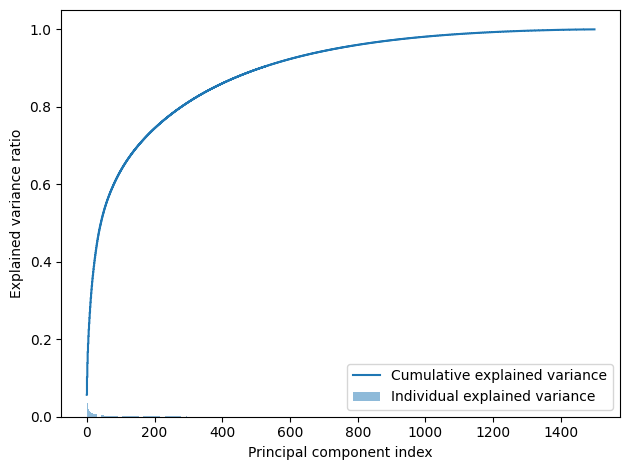

In [20]:
cum_sum_eigenvalues = np.cumsum(explained_variance_ratio)
#
# Create the visualization plot
#
plt.bar(range(0,len(explained_variance_ratio)), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The 400 features majorly explains more than 80% of variance in data.

In [ ]:
pca.components_.shape

(1500, 1500)

In [ ]:
business_review_features.columns

Index(['00', '10', '10 minutes', '100', '11', '12', '14', '15', '15 minutes',
       '20',
       ...
       'ya', 'yeah', 'year', 'years', 'years ago', 'yelp', 'yes', 'young',
       'yum', 'yummy'],
      dtype='object', length=1500)

In [28]:
# for every business id we have highest feature values

components = pd.DataFrame(data=pca.components_, columns = business_review_features.columns)
for i in range(6):
    component = components.loc[i].sort_values(ascending=False)
    print(" component {}:\n".format(i), component[:7])

 component 0:
 food          0.453530
shrimp        0.191050
restaurant    0.188012
good          0.165978
chicken       0.163488
service       0.152346
fried         0.141578
Name: 0, dtype: float64
 component 1:
 bar          0.535227
drinks       0.227781
bartender    0.204986
great        0.176726
music        0.175469
night        0.160426
place        0.158275
Name: 1, dtype: float64
 component 2:
 pizza       0.685403
delivery    0.083868
pizzas      0.078234
crust       0.073618
wings       0.064168
bar         0.059924
order       0.057147
Name: 2, dtype: float64
 component 3:
 pizza          0.588831
coffee         0.496322
breakfast      0.138118
great          0.122270
service        0.108043
coffee shop    0.105536
place          0.105007
Name: 3, dtype: float64
 component 4:
 po          0.246304
fries       0.193927
chicken     0.191803
po boy      0.186565
bar         0.171966
sandwich    0.169144
burger      0.155966
Name: 4, dtype: float64
 component 5:
 po          0

In [20]:
# keep only the top 300 PCA components
business_pca_reduced = pd.DataFrame(business_pca_features[:,:400], index=business_review_features.index, columns=[str(i) for i in np.arange(1,401)])
# business_pca_reduced.columns.name = 'pca_components'

In [21]:
# business_pca_features must be none for some memory free
business_pca_features = None

In [32]:
business_pca_reduced

,1,2,3,4,5,6,7,8,9,10,...,391,392,393,394,395,396,397,398,399,400
business_id,,,,,,,,,,,,,,,,,,,,,
--x_BmZbxzK_nx_GHBaRVw,-0.284747,-0.082094,0.028375,-0.205539,-0.173339,0.170608,-0.094065,0.029220,0.033835,-0.305236,...,-0.021070,-0.002330,-0.014661,-0.023116,-0.012500,0.016407,-0.001140,-0.005913,-0.004386,0.009059
--zb12mw2YK-7j6UaHzm8w,-0.094956,-0.109909,0.028544,-0.137011,-0.011003,0.075087,-0.015234,-0.016755,-0.055615,-0.023716,...,0.092397,-0.004527,-0.007317,-0.040238,0.022432,-0.037123,-0.031353,-0.039589,0.020403,0.030187
-0__F9fnKt8uioCKztF5Ww,-0.019653,0.398369,-0.033249,0.142831,0.003105,-0.077039,-0.041729,-0.062158,0.035758,0.030936,...,-0.016126,-0.000727,-0.013075,0.016305,0.011315,0.014745,0.009740,-0.028118,-0.023963,0.028135
-0ltw8--HLuulPyOSspqAQ,-0.041042,0.021467,-0.049796,0.012774,-0.074113,0.034582,0.110097,0.071629,0.110778,-0.122093,...,0.013767,-0.001406,-0.013949,-0.023020,-0.023215,-0.013308,0.000219,0.009493,-0.016186,-0.015554
-1XSzguS6XLN-V6MVZMg2A,0.320177,0.066783,-0.031455,0.042443,-0.261221,0.136375,-0.046169,-0.002805,0.009658,0.006881,...,0.005955,0.012731,0.019358,0.018553,0.011945,-0.035127,0.019916,0.012197,0.027653,0.013080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zvGNZF827KyzLupKiG4Xtw,-0.069333,0.299794,0.045048,-0.039500,0.137863,0.107822,-0.068616,0.016309,0.014462,0.014649,...,-0.008781,-0.010095,-0.002496,-0.012427,-0.010026,0.008436,0.005572,0.021858,0.009232,0.006378
zwe9H6Xxqb1_E09A20Ptgg,0.235382,0.147065,-0.031914,0.030498,-0.126265,0.112114,0.044183,0.014201,0.014694,0.022856,...,-0.011085,-0.014844,-0.002223,-0.003686,-0.003908,-0.018839,-0.052233,0.019857,0.017822,-0.001575
zxfqXVgZ_NvLY2lc1DAlJQ,0.137655,-0.031268,0.015195,-0.055917,-0.102085,0.090383,-0.158923,0.102595,-0.078203,-0.049479,...,-0.010289,-0.021156,-0.029585,0.001903,0.007333,0.009566,-0.038065,-0.012718,0.008816,-0.042834


User feature vector

In [33]:
# to build the preference profile.. we must have weights multiplied by user star ratings.
# therefore we need to rescale the features

In PCA, we essentially create a new factor with the original variables in a linear combination manner such that: 𝑌1=𝑎11×𝑥1+𝑎12×𝑥2+𝑎1𝑝×𝑥𝑝
.

The sum of squared loadings of all variables (features) for each PC sum to 1. Therefore, is it safe to say that factor 𝑖
 contributes the squared loading amount to the PC 𝑗
?



In [22]:
business_pca_reduced['root_squared_sum'] = business_pca_reduced.apply(lambda row: np.sqrt(sum([i*i for i in row])), axis=1)
business_pca_reduced = business_pca_reduced.drop('root_squared_sum',axis=1).divide(business_pca_reduced.root_squared_sum, axis=0)
business_pca_reduced.head()

,1,2,3,4,5,6,7,8,9,10,...,391,392,393,394,395,396,397,398,399,400
business_id,,,,,,,,,,,,,,,,,,,,,
--x_BmZbxzK_nx_GHBaRVw,-0.288890,-0.083289,0.028788,-0.208529,-0.175861,0.173090,-0.095433,0.029645,0.034327,-0.309677,...,-0.021377,-0.002364,-0.014874,-0.023452,-0.012682,0.016646,-0.001156,-0.005999,-0.004450,0.009191
--zb12mw2YK-7j6UaHzm8w,-0.113795,-0.131715,0.034207,-0.164193,-0.013186,0.089984,-0.018256,-0.020079,-0.066649,-0.028421,...,0.110728,-0.005425,-0.008769,-0.048221,0.026883,-0.044488,-0.037573,-0.047443,0.024450,0.036175
-0__F9fnKt8uioCKztF5Ww,-0.027741,0.562309,-0.046932,0.201610,0.004383,-0.108742,-0.058902,-0.087738,0.050473,0.043667,...,-0.022763,-0.001026,-0.018456,0.023015,0.015972,0.020813,0.013749,-0.039689,-0.033825,0.039714
-0ltw8--HLuulPyOSspqAQ,-0.054333,0.028420,-0.065923,0.016911,-0.098115,0.045781,0.145753,0.094826,0.146655,-0.161634,...,0.018225,-0.001862,-0.018467,-0.030475,-0.030734,-0.017618,0.000290,0.012568,-0.021428,-0.020592
-1XSzguS6XLN-V6MVZMg2A,0.434763,0.090683,-0.042712,0.057633,-0.354708,0.185181,-0.062692,-0.003809,0.013114,0.009343,...,0.008086,0.017287,0.026286,0.025192,0.016220,-0.047699,0.027044,0.016562,0.037550,0.017761


In [ ]:
# now we can merge to get the weighted average to find the stars

In [23]:
%%time
user_pca_features = pd.merge(train[['user_id','business_id','stars']], business_pca_reduced, how='inner',left_on='business_id',right_index=True).drop('business_id', axis=1)


CPU times: user 1.22 s, sys: 2.78 s, total: 4 s
Wall time: 4.87 s


In [39]:
user_pca_features.head()

,user_id,stars,1,2,3,4,5,6,7,8,...,391,392,393,394,395,396,397,398,399,400
0,bcjbaE6dDog4jkNY91ncLQ,4.0,0.228289,-0.000689,0.004863,0.050809,0.173714,-0.111424,-0.01729,-0.320621,...,0.008881,0.048076,0.013605,-0.003199,-0.011316,-0.022597,-0.016278,-0.023498,0.023283,0.042194
1,aG7fzKXqZuG-0vW6NFt8zA,5.0,0.228289,-0.000689,0.004863,0.050809,0.173714,-0.111424,-0.01729,-0.320621,...,0.008881,0.048076,0.013605,-0.003199,-0.011316,-0.022597,-0.016278,-0.023498,0.023283,0.042194
2,mUIww29FcFs5E67eZsMdvw,5.0,0.228289,-0.000689,0.004863,0.050809,0.173714,-0.111424,-0.01729,-0.320621,...,0.008881,0.048076,0.013605,-0.003199,-0.011316,-0.022597,-0.016278,-0.023498,0.023283,0.042194
3,uzHh5QORBRg8PkO4yg4rIg,5.0,0.228289,-0.000689,0.004863,0.050809,0.173714,-0.111424,-0.01729,-0.320621,...,0.008881,0.048076,0.013605,-0.003199,-0.011316,-0.022597,-0.016278,-0.023498,0.023283,0.042194
4,3bRv6h4oOu1lk7N0EEi4DA,5.0,0.228289,-0.000689,0.004863,0.050809,0.173714,-0.111424,-0.01729,-0.320621,...,0.008881,0.048076,0.013605,-0.003199,-0.011316,-0.022597,-0.016278,-0.023498,0.023283,0.042194


In [24]:
%%time
user_pca_features.loc[:, '1':'400'] = user_pca_features.loc[:,'1':'400'].multiply(user_pca_features.stars, axis=0)
user_pca_features.head()

CPU times: user 1.89 s, sys: 1.67 s, total: 3.56 s
Wall time: 3.1 s


,user_id,stars,1,2,3,4,5,6,7,8,...,391,392,393,394,395,396,397,398,399,400
0,bcjbaE6dDog4jkNY91ncLQ,4.0,0.913157,-0.002754,0.019454,0.203234,0.694855,-0.445695,-0.06916,-1.282482,...,0.035524,0.192304,0.054418,-0.012797,-0.045263,-0.090386,-0.065111,-0.093991,0.093134,0.168777
1,aG7fzKXqZuG-0vW6NFt8zA,5.0,1.141447,-0.003443,0.024317,0.254043,0.868568,-0.557119,-0.08645,-1.603103,...,0.044404,0.240380,0.068023,-0.015997,-0.056578,-0.112983,-0.081388,-0.117489,0.116417,0.210971
2,mUIww29FcFs5E67eZsMdvw,5.0,1.141447,-0.003443,0.024317,0.254043,0.868568,-0.557119,-0.08645,-1.603103,...,0.044404,0.240380,0.068023,-0.015997,-0.056578,-0.112983,-0.081388,-0.117489,0.116417,0.210971
3,uzHh5QORBRg8PkO4yg4rIg,5.0,1.141447,-0.003443,0.024317,0.254043,0.868568,-0.557119,-0.08645,-1.603103,...,0.044404,0.240380,0.068023,-0.015997,-0.056578,-0.112983,-0.081388,-0.117489,0.116417,0.210971
4,3bRv6h4oOu1lk7N0EEi4DA,5.0,1.141447,-0.003443,0.024317,0.254043,0.868568,-0.557119,-0.08645,-1.603103,...,0.044404,0.240380,0.068023,-0.015997,-0.056578,-0.112983,-0.081388,-0.117489,0.116417,0.210971


In [25]:
user_pca_features = user_pca_features.drop('stars',axis=1)
user_pca_features.groupby('user_id').sum()

,1,2,3,4,5,6,7,8,9,10,...,391,392,393,394,395,396,397,398,399,400
user_id,,,,,,,,,,,,,,,,,,,,,
---UgP94gokyCDuB5zUssA,1.404423,-0.828304,-1.403485,0.565521,-1.099309,0.468058,0.554445,-0.985768,-1.203278,-0.267186,...,0.049581,-0.013846,0.093999,0.068288,-0.137987,0.069645,-0.011778,-0.006461,0.076190,-0.049964
--1orhUoGFSdHXsoxqQc8g,0.470129,0.117514,-0.048433,0.085268,-0.199295,0.296855,0.034942,0.045616,0.029369,-0.112484,...,0.007520,-0.000426,0.006069,-0.013949,0.011595,-0.012698,0.013217,-0.009756,-0.005731,0.007219
--3PldvWEZ_bhLNsyrAtgA,0.308385,-0.414238,0.187117,-0.556694,0.154929,-0.331265,-0.760246,-0.969927,-0.526195,-0.251822,...,0.003899,0.008221,0.003738,-0.024765,-0.003874,0.017000,0.043546,0.034966,0.047535,-0.092276
--3WaS23LcIXtxyFULJHTA,0.184333,-0.096599,0.097547,-0.813949,1.303147,1.587541,-0.750296,0.097712,-0.564140,0.363436,...,0.013929,0.045343,0.058654,-0.085509,0.041840,-0.099063,-0.022031,-0.095500,0.061220,-0.010111
--48iehfEvtnSrLq8grJIQ,0.333830,5.245972,-0.242880,0.829936,0.453507,0.767508,-0.799803,-1.705718,-1.628687,0.386898,...,-0.379794,-0.080033,0.233026,-0.180037,0.078617,0.207861,-0.060289,-0.196644,-0.015637,0.124896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzq6Nhcq0JMbm7ExFFCP2A,3.501157,0.483887,-0.367337,-0.150268,0.999562,2.703044,0.680216,1.348938,0.234433,-0.355894,...,-0.016251,0.161117,-0.081554,-0.167821,-0.097698,0.029554,-0.125064,-0.112930,-0.076880,0.004545
zzqK0h_3FLhcKbX5H6rDZA,-0.048080,-1.576039,3.483947,2.414015,0.365816,-0.067527,0.627503,0.296653,0.253937,0.026760,...,0.032496,-0.060401,-0.070909,0.017133,-0.001215,0.075105,-0.028936,0.071074,-0.065282,-0.054778
zzsqjDvanJhH9tn8NautOQ,3.701426,0.751097,-0.604641,0.809426,0.042008,0.966598,0.551413,0.477076,0.209367,-0.724127,...,-0.041934,-0.099515,-0.069958,-0.050291,0.010232,0.056094,-0.133705,-0.079394,-0.147560,-0.011549


In [26]:
user_pca_features = user_pca_features.groupby('user_id').sum()

In [27]:
# make all these vectors too of unit length
user_pca_features['root_squared_sum'] = user_pca_features.apply(lambda row: np.sqrt(sum([i*i for i in row])), axis=1)
user_pca_features = user_pca_features.drop('root_squared_sum', axis=1).divide(user_pca_features.root_squared_sum, axis=0)


In [28]:
# pickling these 2 files to use further

In [29]:
import pickle

In [30]:
%%time


with open('business_pca_features_train.pkl','wb') as f:
    pickle.dump(business_pca_reduced, f)
    

max_bytes = 2**31 - 1
bytes_out = pickle.dumps(user_pca_features)
with open('user_pca_features_train.pkl','wb') as f:
    for idx in range(0, len(bytes_out), max_bytes):
        f.write(bytes_out[idx:idx+max_bytes])

CPU times: user 544 ms, sys: 1.43 s, total: 1.97 s
Wall time: 3.6 s


In [31]:
business_pca_reduced = None
user_pca_features = None